# Electric Vehicle Detection
This is a simple pipline that allows us to analyse smart meter data from houses (at 30 min intervals), to detect if they have an EV and when it is charging, by training classifiers to detect if the house has an electric vehicle and when that electric vehicle is charging.


Written by:
Robin Schucker (schucker.robin@gmail.com)

05/31/16

# 1. Data exploration and vizualisation

## 1.1 Import and quick checks

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import cross_validation
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
import scipy.special as spp
import statsmodels.api as sm
import csv

# to plot inside the notebook
%matplotlib inline

test_set = pd.read_csv("EV_test.csv")
train_set = pd.read_csv("EV_train.csv")
train_label = pd.read_csv("EV_train_labels.csv")

# data is transposed so that each column is realitve to one house
# make house ID column headers
train_set.index = train_set["House ID"]
train_set = train_set.transpose()
train_set = train_set.reindex(train_set.index.drop("House ID"))
test_set.index = test_set["House ID"]
test_set = test_set.transpose()
test_set_na = test_set.reindex(test_set.index.drop("House ID"))
train_label.index = train_label["House ID"]
train_label = train_label.transpose()
train_label = train_label.reindex(train_label.index.drop("House ID"))

In [2]:
# check for missing values
print 'train_set has missing values (number of houses): {}'.format(train_set.isnull().any().sum())
print 'test_set has missing values (number of houses): {}'.format(test_set.isnull().any().sum())
print 'train_label has missing values (number of houses): {}'.format(train_label.isnull().any().sum())

# take out missing values
train_label = train_label.loc[:,~train_set.isnull().any()]
train_set = train_set.loc[:,~train_set.isnull().any()]
test_set = test_set_na.dropna(axis=1)


train_set has missing values (number of houses): 4
test_set has missing values (number of houses): 2
train_label has missing values (number of houses): 0


In [3]:
# see what the data looks like
print "train set shape: {}".format(train_set.shape)
print "test set shape: {}".format(test_set.shape)
train_set.head(10)

train set shape: (2880, 1586)
test set shape: (2880, 697)


House ID,11655099,11633257,11651552,11636092,11647239,11636875,11636392,11654157,11655054,11635803,...,11654279,11643663,11647508,11647096,11646944,11646330,11644267,11652832,11633186,11650303
Interval_1,0.950,0.353,0.150,2.088,1.416000,1.124,0.103,0.685,1.113,0.433,...,0.037,0.535,1.061,0.410,0.569,0.211,0.107,0.738,2.952,0.825
Interval_2,0.826,0.327,0.181,2.075,1.250000,0.995,0.126,0.691,1.098,0.412,...,0.026,0.529,1.018,0.285,0.574,0.196,0.116,1.690,2.406,0.894
Interval_3,0.361,0.358,0.150,2.121,1.270000,0.792,0.237,0.701,1.355,0.378,...,0.054,0.522,0.573,0.290,0.250,0.276,0.116,0.755,2.081,0.875
Interval_4,0.238,0.292,0.150,2.098,1.258000,1.256,0.209,0.689,1.513,0.393,...,0.046,0.670,0.543,0.265,0.079,0.328,0.107,0.795,2.032,0.900
Interval_5,0.342,0.285,0.131,2.046,1.239000,0.996,0.183,0.712,1.503,0.399,...,0.026,2.160,0.563,0.305,0.055,0.501,0.118,0.750,1.994,0.319
Interval_6,0.233,0.304,0.125,2.081,1.753105,1.203,0.178,0.693,1.493,0.400,...,0.046,1.699,0.445,0.273,0.055,0.204,0.104,0.810,1.969,0.200
Interval_7,0.351,0.361,0.088,1.847,4.609256,1.610,0.198,0.698,1.490,0.400,...,0.104,1.694,0.518,0.308,0.055,0.200,0.117,0.805,2.012,0.331
Interval_8,0.194,0.342,0.106,0.420,4.619256,1.562,0.132,0.709,1.348,0.342,...,0.079,1.695,0.403,0.325,0.381,0.203,0.107,1.650,2.000,0.281
Interval_9,0.292,0.355,0.094,0.399,4.075151,1.056,0.114,0.699,1.475,0.347,...,0.191,1.664,0.553,0.295,0.580,0.145,0.114,2.115,1.989,0.344
Interval_10,0.234,0.348,1.019,0.364,1.230000,1.374,0.221,0.724,1.455,0.850,...,0.499,1.676,0.515,0.270,0.577,0.198,0.118,1.370,2.004,0.188


In [4]:
train_set.describe()

House ID,11655099,11633257,11651552,11636092,11647239,11636875,11636392,11654157,11655054,11635803,...,11654279,11643663,11647508,11647096,11646944,11646330,11644267,11652832,11633186,11650303
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,...,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,0.569631,0.667629,0.659690,1.397184,1.423121,0.774164,0.725455,0.429989,2.420593,1.091872,...,0.733200,1.383969,0.737127,0.831141,0.440738,0.456259,0.756931,3.276137,1.322499,1.019270
std,0.366291,0.489821,0.736209,0.864061,0.547277,0.462288,0.535063,0.215136,2.185808,1.057931,...,0.793438,1.101420,0.895967,0.878406,0.514761,0.306160,0.327059,3.208238,1.212473,1.083398
min,0.160000,0.132000,0.025000,0.236000,0.765000,0.062000,0.066000,0.029000,0.000000,0.000000,...,0.000000,0.138000,0.118000,0.130000,0.040000,0.062000,0.000000,0.623000,0.050000,0.144000
25%,0.300000,0.318000,0.119000,0.795750,1.220000,0.407000,0.266000,0.245750,1.125000,0.465000,...,0.072000,0.370750,0.306000,0.272250,0.070000,0.220000,0.588000,0.840000,0.151000,0.350000
50%,0.445000,0.465000,0.356000,1.036500,1.251000,0.706500,0.617500,0.482500,1.289000,0.621000,...,0.260500,1.582000,0.437000,0.383000,0.310000,0.321000,0.600000,1.293000,0.928000,0.581000
75%,0.746000,0.922250,0.981000,2.156250,1.449500,1.044000,1.055000,0.549000,3.113000,1.253250,...,1.442750,1.824250,0.779250,1.241250,0.587000,0.731000,1.195250,6.695000,2.126250,1.013000
max,2.170000,3.842000,4.788000,4.119000,6.993877,2.755000,3.687000,1.746000,11.462256,6.617074,...,3.416000,7.033256,7.137439,6.585000,3.718000,2.134000,1.553000,11.048000,4.378000,6.531256


In [5]:
train_label.describe()

House ID,11655099,11633257,11651552,11636092,11647239,11636875,11636392,11654157,11655054,11635803,...,11654279,11643663,11647508,11647096,11646944,11646330,11644267,11652832,11633186,11650303
count,2880,2880,2880,2880,2880.000000,2880,2880,2880,2880.000000,2880.000000,...,2880,2880.000000,2880.000000,2880,2880,2880,2880,2880,2880,2880.000000
mean,0,0,0,0,0.040625,0,0,0,0.071875,0.077431,...,0,0.068403,0.069792,0,0,0,0,0,0,0.079514
std,0,0,0,0,0.197454,0,0,0,0.258326,0.267320,...,0,0.252480,0.254840,0,0,0,0,0,0,0.270586
min,0,0,0,0,0.000000,0,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0,0,0,0.000000
25%,0,0,0,0,0.000000,0,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0,0,0,0.000000
50%,0,0,0,0,0.000000,0,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0,0,0,0.000000
75%,0,0,0,0,0.000000,0,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0,0,0,0,0,0,0.000000
max,0,0,0,0,1.000000,0,0,0,1.000000,1.000000,...,0,1.000000,1.000000,0,0,0,0,0,0,1.000000


In [6]:
# split data into houses that have EV and those that do not
train_EV = train_set.loc[:, train_label.mean() > 0.001]
train_noEV = train_set.loc[:,train_label.mean() <= 0.001]
train_label_EV = train_label.loc[:, train_label.mean() > 0.001]
train_label_noEV = train_label.loc[:, train_label.mean() <= 0.001]

print "number of houses with EVs in train set: {}".format(train_EV.shape[1])
print "number of houses with no EVs in train set: {}".format(train_noEV.shape[1])

number of houses with EVs in train set: 484
number of houses with no EVs in train set: 1102


## 1.2 Data Visualization
(To plot different samples, relaod the next two cells)

In [7]:
# Select random samples in the training data and plot sample
# ----------------------------------------------------------

# select random house with EV
sample_house_EV = train_EV.sample(n=1, axis=1)
sample_label_EV = train_label[sample_house_EV.columns.values]

# select random house with no EV
sample_house_noEV = train_noEV.sample(n=1, axis=1)
sample_label_noEV = train_label[sample_house_noEV.columns.values]

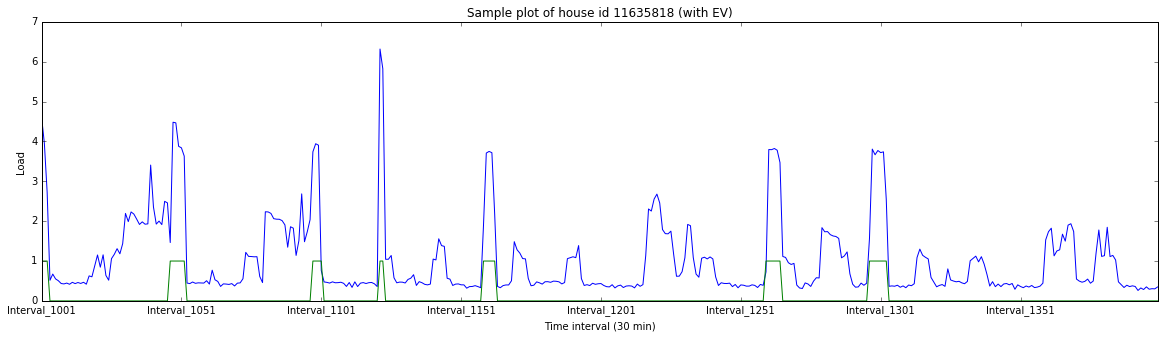

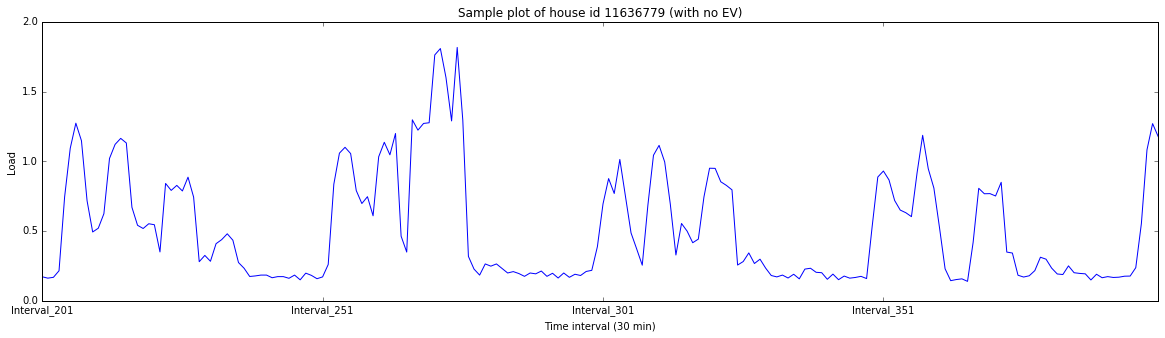

In [8]:
start = 1000
end = 1400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_EV[start:end].plot(ax=ax, legend=False)
sample_label_EV[start:end].plot(ax=ax, legend=False, color='g')
plt.title('Sample plot of house id {} (with EV)'.format(int(sample_house_EV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

start = 200
end = 400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_noEV[start:end].plot(ax=ax, legend=False)
sample_label_noEV[start:end].plot(ax=ax, legend=False, color='g')
plt.title('Sample plot of house id {} (with no EV)'.format(int(sample_house_noEV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

We see that when an EV is being charged, there is a substantial peak in the load. Some are very well defined and can be easily be separated from the load, some blend in with the natural spikes and variability.
The houses that have no EVs show less "spiky" loads but we can already see that this won't be an easy task for every house.

## 1.3 First thoughts on feature engineering
## 1.3.1 Moving average

We want to determine two things from the data: (i) if the house has an EV and (ii) for each time point, if it is charging. As we saw when plotting the data, we will have to identify the short and strong peaks that occur and classify them as EV chargin peaks or not. To locate these peak, a frist naive approach would be to compare the load with its mean value over the two months. This would not work well as the load is highly variable throughout the day and the month. A more sophisticated, yet simple approach is to look at the current load compared to a moving average of the last n points (n=10 seems to produce good results).


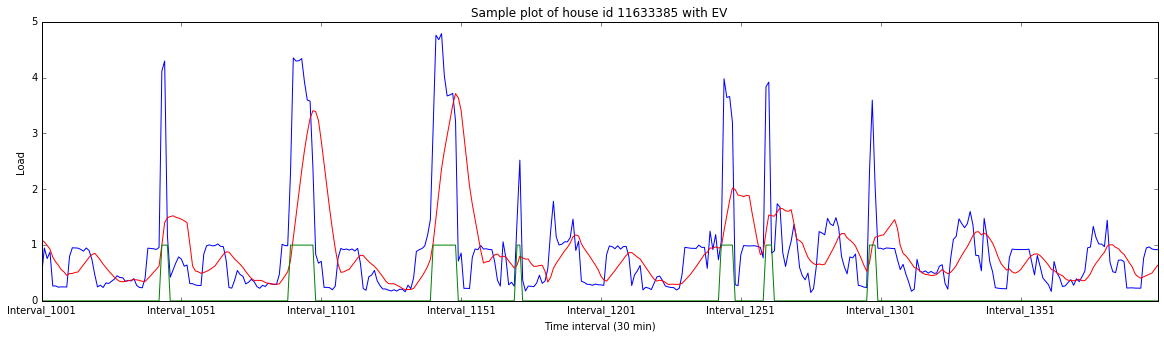

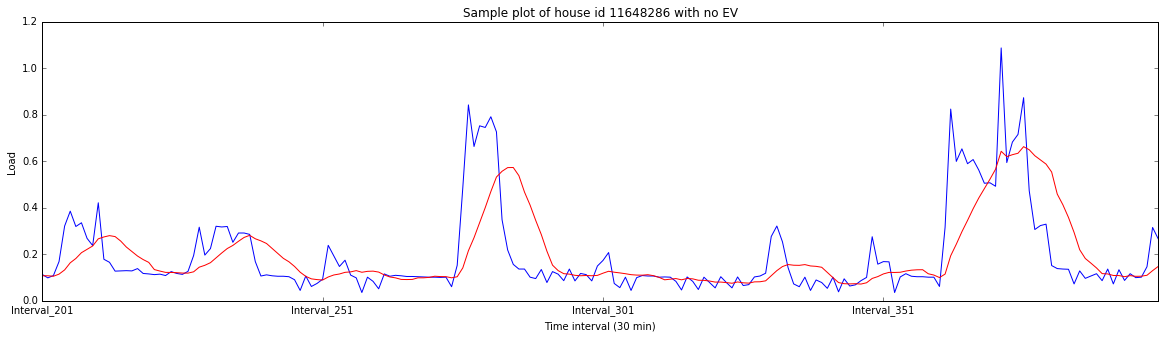

In [10]:
# select random house with EV
sample_house_EV = train_EV.sample(n=1, axis=1)
sample_label_EV = train_label[sample_house_EV.columns.values]

# select random house with no EV
sample_house_noEV = train_noEV.sample(n=1, axis=1)
sample_label_noEV = train_label[sample_house_noEV.columns.values]

# create moving average
mva_window = 10
sample_house_EV_mva = pd.rolling_mean(sample_house_EV, mva_window)
sample_house_noEV_mva = pd.rolling_mean(sample_house_noEV, mva_window)

# plot that random house
start = 1000
end = 1400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_EV[start:end].plot(ax=ax, legend=False)
sample_house_EV_mva[start:end].plot(ax=ax, legend=False, color='r')
sample_label_EV[start:end].plot(ax=ax, legend=False, color='g')
plt.title('Sample plot of house id {} with EV'.format(int(sample_house_EV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

start = 200
end = 400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_noEV[start:end].plot(ax=ax, legend=False)
sample_house_noEV_mva[start:end].plot(ax=ax, legend=False, color='r')
sample_label_noEV[start:end].plot(ax=ax, legend=False, color='g')
plt.title('Sample plot of house id {} with no EV'.format(int(sample_house_noEV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

We can see that the moving average (in red) is a good representation of a smoothed load, and the short peaks are characterized with a large difference with respect to the moving average while longer peaks have a positive difference during the start of peak and then a negative difference after the peak (as the peak is now incorporated inside the moving average). For each time point, looking at the difference with the moving average of that time point and the neighbors around it could be a good set of features.

## 1.3.2 Seasonal Decomposition and Autocorellation
Another approach is trying to model the daily load as we know it is usually very cyclical. Each charging point could be viewed as an anomaly versus the "usual" modeled cyclic load. Finding that cyclycity can be done using a seasonal-trend decomposition provided by the statsmodels API (http://statsmodels.sourceforge.net/). A weakness of this approach is that if the EV charging is cyclic (for example every day at 5pm when getting home from work), it will be incorporated inside the cyclic component and not cosidered as an anomaly.

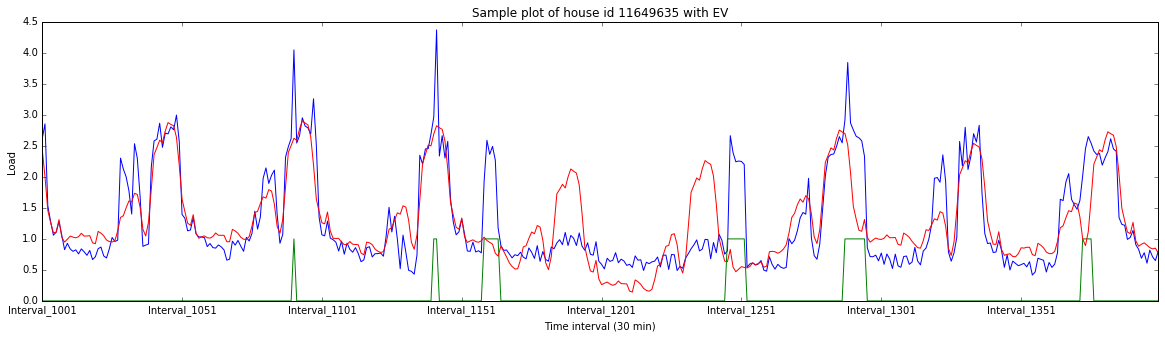

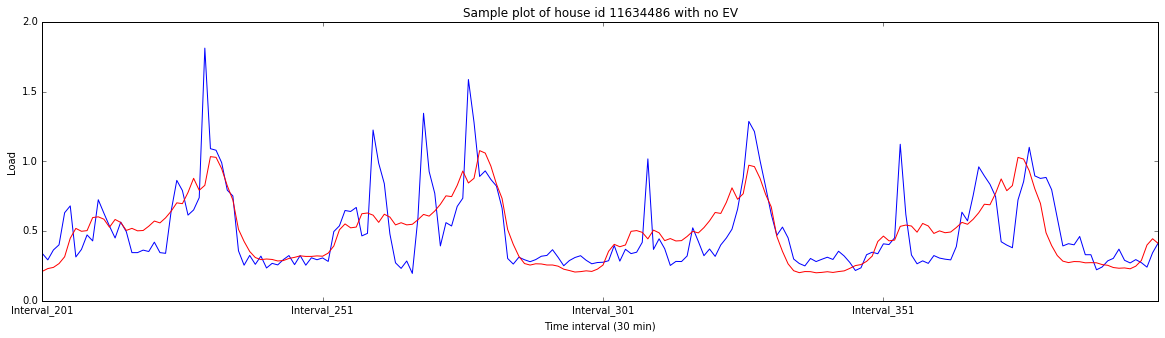

In [11]:
# select random house with EV
sample_house_EV = train_EV.sample(n=1, axis=1)
sample_label_EV = train_label[sample_house_EV.columns.values]

# select random house with no EV
sample_house_noEV = train_noEV.sample(n=1, axis=1)
sample_label_noEV = train_label[sample_house_noEV.columns.values]

#ST decomposition
f = 48 #one day frequency
res_EV = sm.tsa.seasonal_decompose(sample_house_EV.as_matrix().reshape(-1), freq=f)
modeled_load_EV = res_EV.seasonal + res_EV.trend # modeled load
res_noEV = sm.tsa.seasonal_decompose(sample_house_noEV.as_matrix().reshape(-1), freq=f)
modeled_load_noEV = res_noEV.seasonal + res_noEV.trend # modeled load

# plot that random house
start = 1000
end = 1400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_EV[start:end].plot(ax=ax, legend=False)
sample_label_EV[start:end].plot(ax=ax, legend=False, color='g')
plt.plot(modeled_load_EV[start:end], color='r')
plt.title('Sample plot of house id {} with EV'.format(int(sample_house_EV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

start = 200
end = 400
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
sample_house_noEV[start:end].plot(ax=ax, legend=False)
sample_label_noEV[start:end].plot(ax=ax, legend=False, color='g')
plt.plot(modeled_load_noEV[start:end], color='r')
plt.title('Sample plot of house id {} with no EV'.format(int(sample_house_noEV.columns.values[0])))
plt.xlabel('Time interval (30 min)')
plt.ylabel('Load')
plt.show()

This seems to work very well for some houses and not so well for others (running the cell above several times shows a plot for different houses).

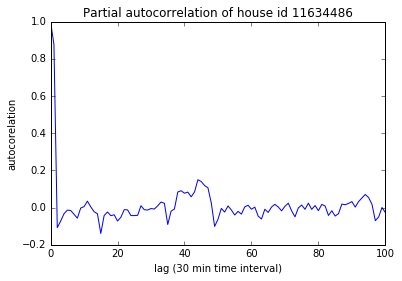

In [12]:
acf = sm.tsa.stattools.pacf(sample_house_EV.as_matrix().reshape(-1), nlags=100)
fig = plt.figure()
plt.plot(acf)
plt.xlabel("lag (30 min time interval)")
plt.ylabel("autocorelation")
plt.title("Partial autocorrelation of house id {}".format(int(sample_house_noEV.columns.values[0])))
plt.show()

There does not seem to be a significant autocorralation for most of the houses, sometimes a small peak at 48 (48x30min = 1 day), showing a day to day correlation.

From these preliminary results, I will use the difference from the moving average as main metric to create features because it is both simple and seems to produce good results.

## 1.3.3 Summary statistics for classification

The first step is to build a classifier to detect if the house has an EV or not. As metionned above, the difference with respect to the moving average seems to be (visualy at least) a good indicator as to when there are peaks. For each house that gives us 2800 points, which seems too many feature per house. Moreover, the time at which the peaks occurs is irrelevent. What we are interested in is how frequently those sharp peaks occur. A more meaningfull set of features would be to look at the histogram of difference of the load with the mean. If a house has an EV, we expect it to have more sharp peaks in load an thus a broader histogram. Another interesting metric would be the first derivative of the load (Load(t) - Load(t-1)), and if we look at the histogram of that value we expect it to have more extreme values for a house that has an EV.

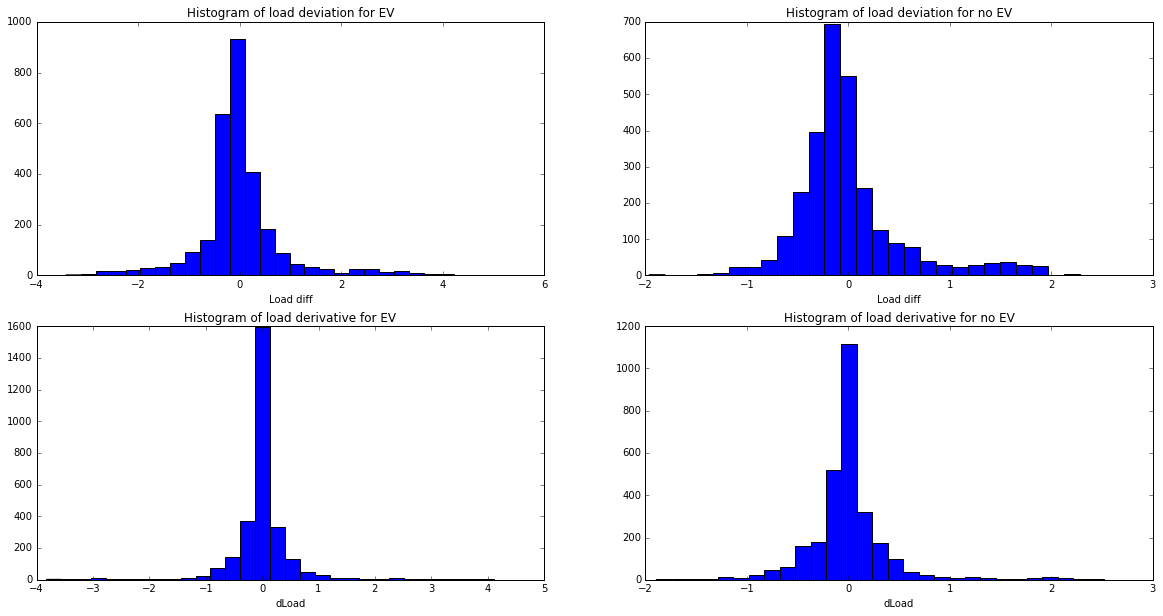

In [13]:
# select random house with EV
sample_house_EV = train_EV.sample(n=1, axis=1, random_state=None)

# select random house with no EV
sample_house_noEV = train_noEV.sample(n=1, axis=1, random_state=None)

# create moving average of EV house load:
mva_window = 10
sample_house_EV_mva = pd.rolling_mean(sample_house_EV, mva_window)
sample_house_noEV_mva = pd.rolling_mean(sample_house_noEV, mva_window)

# Plot histogram
X_EV = sample_house_EV.as_matrix()[mva_window-1:] - sample_house_EV_mva.as_matrix()[mva_window-1:]
X_EV = X_EV.reshape((-1,))
X_noEV = sample_house_noEV.as_matrix()[mva_window-1:] - sample_house_noEV_mva.as_matrix()[mva_window-1:]
X_noEV = X_noEV.reshape((-1,))

dX_EV = sample_house_EV.as_matrix()[mva_window-1:] - sample_house_EV.as_matrix()[mva_window-2:-1]
dX_EV = dX_EV.reshape((-1,))
dX_noEV = sample_house_noEV.as_matrix()[mva_window-1:] - sample_house_noEV.as_matrix()[mva_window-2:-1]
dX_noEV = dX_noEV.reshape((-1,))


fig = plt.figure(figsize=(20,10))
plt.subplot(221)
plt.hist(X_EV,30)
plt.title("Histogram of load deviation for EV")
plt.xlabel("Load diff")

plt.subplot(222)
plt.hist(X_noEV,30)
plt.title("Histogram of load deviation for no EV")
plt.xlabel("Load diff")

plt.subplot(223)
plt.hist(dX_EV,30)
plt.title("Histogram of load derivative for EV")
plt.xlabel("dLoad")

plt.subplot(224)
plt.hist(dX_noEV,30)
plt.title("Histogram of load derivative for no EV")
plt.xlabel("dLoad")
plt.show()

As expected, the house with an EV has a histogram that spans over much wider values.

# 2. Classifier for to determine if the house has an EV
## 2.1 Create features

In [14]:
''' 
function that computes the features for a set of time series. The features are the standard deviation of the difference
of the load with the running mean, the standard deviation of the time derivative, and a scaled histogram of the
difference and histogram of the time derivative. The first feature, is simply the mean of the load as it might be
and indication of the wealth of the persons living in the house.
input:
   Xdf: panda dataframe of shape (T,Nh) with T = num time intervals, Nh = num houses
   ydf: panda dataframe of shape (T,Nh) where ydf[t,i] = 1 if house i has an EV charging at time t, 0 otherwise
   mva_window: size of moving average window for mean caluclation
   n_buckets = number of buckets for histogram. Must be at least 2
   std_range = number of std the buckets should span
   _mean for histogram relative to difference to rolling mean
   _d for histogram relative to first derivative
output:
   X: numpy array of shape (Nh, Nf) with Nf = n_buckets_mean + n_buckets_d + 2
   y: numpy array of shape (Nh,) y[i] = 1 if house i has an EV
   
Note: adding a first derivative histogram only improves the classification by 1-2%
'''

def create_features_house(Xdf, ydf=None, mva_window=10, n_buckets_mean=11, std_range_mean=3, 
                       n_buckets_d = 11, std_range_d=4):
    
    Xdf_mva = pd.rolling_mean(Xdf, mva_window)
    diff = Xdf.as_matrix()[mva_window-1:] - Xdf_mva.as_matrix()[mva_window-1:]
    dX = Xdf.as_matrix()[mva_window-1:] - Xdf.as_matrix()[mva_window-2:-1] #dX = X(t) - X(t-1)
    Nh = diff.shape[1]

    X = np.zeros((Nh,n_buckets_mean + n_buckets_d + 3))
    # feature 1 = std of difference from running mean
    std_mean = diff.std(axis=0)
    std_d = dX.std(axis=0)
    X[:,0] = Xdf.mean().as_matrix()
    X[:,1] = std_mean
    X[:,n_buckets_mean + 2] = std_d
    
    # scale the difference
    diff_scaled = diff / std_mean
    dX_scaled = dX / std_d
    
    #create bucket list and histogram for difference from mean
    buckets_mean = np.zeros(n_buckets_mean + 1)
    buckets_mean[0] = -np.inf
    buckets_mean[-1] = np.inf
    buckets_mean[1:-1] = np.linspace(-std_range_mean, std_range_mean, n_buckets_mean - 1)
    for i in range(Nh):
        hist_mean, edges = np.histogram(diff[:,i], bins = buckets_mean)
        X[i,2:n_buckets_mean + 2] = hist_mean
    
    if (n_buckets_d != 0):
        #create bucket list and histogram for difference from mean
        buckets_d = np.zeros(n_buckets_d + 1)
        buckets_d[0] = -np.inf
        buckets_d[-1] = np.inf
        buckets_d[1:-1] = np.linspace(-std_range_d, std_range_d, n_buckets_d - 1)
        for i in range(Nh):
            hist_d, edges = np.histogram(dX[:,i], bins = buckets_d)
            X[i,n_buckets_mean + 3:] = hist_d
    
    if (ydf is None):
        return X
    
    # y[i] = 1 if house i has an EV
    y = (ydf.mean() > 0.001).as_matrix().astype(int)
        
    return X, y

X_train, y_train = create_features_house(train_set, train_label)

## 2.2 Train an SVM using K-Fold cross validation
I use an SVM instead of Logistic regression because since the histograms are scaled (using the standard deviation), second order terms might have significant importance. An SVM with the "kernel trick" enables us to train a more powerfull classifier than logistic regression.

In [15]:
# preprocess the training data first
mean_X_train = X_train.mean(axis=0)
std_X_train = X_train.std(axis=0)
X_train_scaled = (X_train - mean_X_train) / std_X_train

In [16]:
# Train classifier using cross validation
#---------------------------------
n_folds = 5 # number of folds for cross validation

# classifier
#clf = linear_model.LogisticRegression(C=10.0)
clf = svm.SVC(kernel='rbf', C=1000.0, gamma = 0.01)
y_train_pred = cross_validation.cross_val_predict(clf, X_train_scaled, y_train, cv=n_folds, n_jobs=-1)
print 'F1 Score: {:4.1f}%'.format(metrics.f1_score(y_train, y_train_pred)*100)
print 'Precision: {:4.1f}%'.format(metrics.precision_score(y_train, y_train_pred)*100)
print 'Recall: {:4.1f}%'.format(metrics.recall_score(y_train, y_train_pred)*100)

F1 Score: 78.9%
Precision: 83.9%
Recall: 74.4%


First results indicate that a linear model performs better than logistic regression. An rbf (gaussian) kernel out performs the linear models but we need to do a more rigorous hyperparameter search as we now have two (C and gamma)
After a random parameter search for the polynomial and gaussian kernel we find:
- Linear SVM:
    F1 score = 75.3 (+/-2.1)%
- Logistic Regression:
    F1 score = 73.2 (+/-2.1)%
- Poly kernel SVM:
    F1 score = 74.0 (+/-1.8)%
- Gaussian kernel SVM:
    F1 score = 79.1 (+/-1.9)%

In [17]:
# using random search and cross validation
#---------------------------------
n_folds = 5 # number of folds for cross validation

param_grid = {'kernel': ['rbf'], 'gamma': expon(scale=0.1), 'C': expon(scale=1000)}
#param_grid = {'C': expon(scale=1000)} #for linear kernel and logistic regression

clf = svm.SVC() #best 78% F1 score with rbf kernel and
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,scoring='f1', cv=n_folds, n_iter=100)
random_search.fit(X_train_scaled, y_train)
print random_search.best_params_
print random_search.best_score_

{'kernel': 'rbf', 'C': 187.3260556273185, 'gamma': 0.024841382726880343}
0.79091591566


Once the best parameters have been found, lets retrain the classifier on the whole training set. We should do a more thorough search of the parameters of the create features function but after some manual searching, the set default values seem to work well.

In [18]:
EVhouse_classifier = random_search.best_estimator_
EVhouse_classifier.fit(X_train_scaled, y_train)

SVC(C=187.326055627, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0248413827269,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## 2.3 Predict the Test Set

In [19]:
# Predict the which houses in the test set have an EV
#----------------------------------------------------
X_test = create_features_house(test_set)

# scale the test set using std and mean from the training set
# We use the training set in case the test set is too small
X_test_scaled = (X_test - mean_X_train) / std_X_train
yhouse_test = EVhouse_classifier.predict(X_test_scaled)

## 2.4 Future improvments

To get an improved classifier here are a few steps I would explore next:
- Search for the best hyper parameters used in the create_feature function
- Explore some different features (such as difference from modeled data by seasonal decomposition)
- Use an ensemble method. Boosting is probably best here since we have control over how many features we create. If we use boosting we don't need individual learners that are as strong, we probably don't need to use a gaussian kernel and can use logistic regression (linear_models.LogisticRegression()) or a linear SVM (svm.LinearSVC()) which is much faster than the SVM used above.
- Use additional metadata about the house if possible

# 3. Classifier to determine if house is charging at a specific time

## 3.1 Create features
Now we have to determine at which times the house is charging based solely on its load profile. For this task we will also use the difference from the moving average as main metric. The difference is that now at each point in time t the features will be: the difference with respect to the moving average at t and its neighbors (...t-2, t-1, t+1, t+2...).

In [20]:
''' 
function that computes the features for a set of time series. If Xdf(t,j) is the load at
time t of house j, X(t,:,j) (the returned value) is an array of features of size 
2*f_window + 1 where X(t,f_window,j) is the difference of the load compared to the rolling 
average calculated using mva_window previous points. 
X(t,f_window-1,j) is the difference with the rolling average, both at the
previous time step (X(t,f_window-1,j) == X(t-1,f_window,j)). X(t,f_window+i,j) is the difference
at ith time setp after t.
input:
   Xdf: panda dataframe of shape (T,Nh) with T = num time intervals, Nh = num houses
   ydf: panda dataframe of shape (T,Nh)
   mva_window: size of moving average window for mean caluclation
   f_window: feature window
output:
   X: numpy array of shape (T', Nf, Nh) where T' = T - (mva_window - 1) - 2*f_window
   y: numpy array of shape (T',Nh)
'''

def create_features(Xdf, ydf = None, mva_window = 10, f_window = 3):
    Xdf_mva = pd.rolling_mean(Xdf, mva_window)
    diff = Xdf.as_matrix()[mva_window-1:] - Xdf_mva.as_matrix()[mva_window-1:]

    X = np.zeros((diff.shape[0] - 2*f_window,diff.shape[1], 2*f_window + 1))
    for i in range(2*f_window + 1):
        if (i != 2*f_window):
            X[:,:,i] = diff[i:(-2*f_window + i),:]
        else:
            X[:,:,i] = diff[i:,:]
            
    if (ydf is None):
        return X
    # cutoff y points that won't be predicted (due to moving average and feature window)
    y = ydf.as_matrix()
    y = y[mva_window-1:]
    if (f_window != 0):
        y = y[f_window:-f_window]
    
    return X, y

mva_window = 10 # size of moving average
f_window = 5 #feature window
X, y = create_features(train_EV, train_label_EV, mva_window, f_window)

## 3.2 Train Classifier on small subset of dataset

In [21]:
# collapse time steps and number of houses together in order to obtain an 2D array.
print X.shape
print y.shape
Nf = X.shape[2] #number of features

# reshape in (T*Nh, Nf)
# 0th axis of data corresponds to [house_1/interval_1, ..., house_1/interval_2800, house_2/interval_1...]
X_flat = X.swapaxes(0,1).reshape(-1,Nf)
y_flat = y.ravel(order='F') 

print X_flat.shape
print y_flat.shape

(2861, 484, 11)
(2861, 484)
(1384724, 11)
(1384724,)


We have too many data points (more than 1M!) for any classification to complete in a reasonable runtime. Thus we need to train the classifiers on a subsets of the data points. In practice 4000 points provides a good speed / number of points ratio.

In [22]:
# create smaller train and validation sets for individual learners
X_train_small, _, y_train_small, _ = cross_validation.train_test_split(
    X_flat, y_flat, test_size=0.997, random_state=None)
X_val_small, _, y_val_small,_ = cross_validation.train_test_split(
    X_flat, y_flat, test_size=0.99, random_state=None)
X_train, X_val, y_train, y_val = cross_validation.train_test_split(
    X_flat, y_flat, test_size=0.20, random_state=None)

print X_train_small.shape
print X_train.shape
print X_val_small.shape
print X_val.shape

(4154, 11)
(1107779, 11)
(13847, 11)
(276945, 11)


Using this small training sets enables us to quickly itterate and find a good classifier model. Again here an SVM with a gaussian kernel seems to work best.

In [23]:
# train SVM on train set

#clf = svm.LinearSVC(C=10000.0, random_state=None)
#clf = linear_model.LogisticRegression(C=10.0)
clf = svm.SVC(kernel='rbf', C=10.0, gamma = 0.1, probability=False)
clf.fit(X_train_small, y_train_small)
print "Training error"
y_train_pred = clf.predict(X_train)
print '    F1 Score: {}'.format(metrics.f1_score(y_train, y_train_pred)*100)
print '    Precision: {}'.format(metrics.precision_score(y_train, y_train_pred)*100)
print '    Recall: {}'.format(metrics.recall_score(y_train, y_train_pred)*100)
print "Val_small error"
y_val_small_pred = clf.predict(X_val_small)
print '    F1 Score: {}'.format(metrics.f1_score(y_val_small, y_val_small_pred)*100)
print '    Precision: {}'.format(metrics.precision_score(y_val_small, y_val_small_pred)*100)
print '    Recall: {}'.format(metrics.recall_score(y_val_small, y_val_small_pred)*100)

Training error
    F1 Score: 61.0448886159
    Precision: 75.1099127567
    Recall: 51.4166470727
Val_small error
    F1 Score: 60.8167770419
    Precision: 77.4964838256
    Recall: 50.0454132607


## 3.3 Training a bagging ensemble on the whole training set

Now that we have found a good set of hyperparameters and classification model we can use a bagging algorithm to train many of these small classifiers and average them to get a better classifier. This allows us to get a boost of around 5-10% in the F1 score.

In [24]:
svm_clf = svm.SVC(kernel='rbf', C=10.0, gamma = 0.1)
bag_clf = ensemble.BaggingClassifier(svm_clf, n_estimators = 50, max_samples=5000, n_jobs=-1, verbose=False)
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=5000, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=False, warm_start=False)

In [25]:
y_val_pred_proba = bag_clf.predict_proba(X_val)[:,1] # Warining this takes ~5 min for 100 estimators

In [26]:
# the threshold can be tuned to balance precision and recall as needed
threshold = 0.14
print "Val error"
y_val_pred = (y_val_pred_proba >= threshold).astype(int)
print '    F1 Score: {}'.format(metrics.f1_score(y_val, y_val_pred)*100)
print '    Precision: {}'.format(metrics.precision_score(y_val, y_val_pred)*100)
print '    Recall: {}'.format(metrics.recall_score(y_val, y_val_pred)*100)

Val error
    F1 Score: 67.2469079249
    Precision: 66.4253393665
    Recall: 68.0890538033


# 4. Classify the test set and create final submission

To predict the test set, we will first use the first classifier to determine if the specific house has an EV and then we will use the second classifier to determine at what times the house is likeley to be charging an EV. The way our features were built, we cannot make a prediction on the first (mva_window + f_window - 1) time intervals and the last (f_window) and we will simply set them to zero. We will also not make any prediction on the houses in the test set that have NaNs in them (as a whole chunck of data is missing, not just a few values).

In [27]:
test_set_EV = test_set.loc[:,yhouse_test == 1]
y_test_pred = np.zeros(test_set.shape)

In [28]:
XX_test = create_features(test_set_EV, mva_window=mva_window, f_window=f_window)
T, Nh_test, Nf_test = XX_test.shape
X_test = XX_test.swapaxes(0,1).reshape(-1,Nf_test).copy()

# predict probability
y_test = bag_clf.predict_proba(X_test)[:,1]

# adjust output so that threshold reprensents 0.5 probability
# (y_test > 0.14) == (y_test_proba > 0.50)
y_test_proba = spp.expit(spp.logit(y_test) - spp.logit(threshold)) #shape (T * Nh_test)

In [29]:
# reshape into correct size
y_test_EV = y_test_proba.reshape(Nh_test,T).swapaxes(0,1)

# put predictions in the right place inside output array
y_test_pred[mva_window + f_window - 1:-f_window, yhouse_test == 1] = y_test_EV

# Create panda data frame with right labels
ydf_test_pred = test_set_na.copy()
ydf_test_pred[test_set_na.loc[:,~test_set_na.isnull().any()].columns] = y_test_pred
for col in test_set_na.loc[:,test_set_na.isnull().any()].columns:
    ydf_test_pred[col] = np.zeros(test_set.shape[0])
    
# Save prediction to csv file
ydf_test_pred.transpose().to_csv("submission.csv", quoting=csv.QUOTE_NONNUMERIC)


# 5. Future work

It might be interesting to do the classification in reversed order. First classify each time interval as charging an EV or not and then use that information (along with the other features already used) to classify if the house has an EV or not. For example, a simple feature might be the number of intervals classified as charging for each house. However I expect this approach to decrease the performance of the time specific classifier as now we also have to classify houses that do not have EV and thus the input data comes from an even broader distribution.

Another improvment that can easily be made is seperate weekdays from weekends and train different classifiers for each. Indeed we know that our daily habits (and thus our electricity consumption) is radically different on weekends and thus it makes sense to train seperate alorithms on these two different distributions.

Finally, we can use a radicaly different approach and go towards deep learning. LSTM neural networks have shown to be very succesful on time series data and could very well outperform any traditional machine learning alogorithm if sufficient data is available.

 